In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import solve_ivp

In [107]:
# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({ # todo change font
    'font.family': 'serif',            # Use serif fonts (like in LaTeX)
    'font.serif': ['Times New Roman'], # Use Times New Roman as the serif font
    'font.size': 25,                   # Font size for general text
    'axes.titlesize': 25,              # Font size for axis titles
    'axes.labelsize': 25,              # Font size for axis labels
    'xtick.labelsize': 25,             # Font size for x-axis tick labels
    'ytick.labelsize': 25,             # Font size for y-axis tick labels
    'legend.fontsize': 25,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'text.usetex': False,              # Disable LaTeX usage
    'savefig.format': 'svg'            # Default format for saving figures
})

In [112]:
########################################                 Define constants                   #############################################
n = 3 + 3 * 10
t_max = 100 # final time
N = 100 #iterations for solveivp

hbar=1
fixed_lam = 1
fixed_gamma = 1
fixed_dist_ext = 0.235  * fixed_lam
fixed_dist_in  =  fixed_dist_ext

times  = np.linspace(0, t_max, N) * fixed_gamma
t_span = (0, t_max)

In [113]:
########################################               define the geometry                 #############################################
def phi(t, tau):
    pi_start = np.pi
    pi_end = np.pi / 3
    
    # Define the transition intervals
    t1 = t_max / 5
    t2 = t_max t1 + tau
    
    if t <= t1:
        return pi_start
    elif t >= t2:
        return pi_end
    else:
        # Normalize time to the range [0, pi] for the transition
        normalized_time = ((t - t1) / (t2 - t1)) * np.pi
        
        # Apply sin^2 transition
        sin_squared = np.sin(normalized_time / 2)**2
        
        return pi_start + (pi_end - pi_start) * sin_squared

def dipole_vector(t, tau):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi(t, tau)),np.sin(phi(t, tau)), 0])
    return dipole

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])

def chain_positions(distance, n):
    Pos = np.zeros((n, 3))
    for i in range(n):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, n = n):
    Pos = np.zeros((n, 3))
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(distance_ext, n // 3) + [r, 0, 0]
    Pos[:n//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[n//3:2*n//3] = np.dot(Chain, z_rotation(np.pi / 3).T)
    Pos[2*n//3:] = np.dot(Chain, z_rotation(-np.pi / 3).T)
    return Pos

########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions(distance_in, distance_ext)
    G_matrix = np.zeros((n, n), dtype=complex)
    for a in range(n):
        for b in range(n):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                G_matrix[a, b] = np.imag((6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions(distance_in, distance_ext)
    V_matrix = np.zeros((n, n), dtype=complex)
    for a in range(n):
        for b in range(n):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                V_matrix[a, b] = - np.real((3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix
    
def Hamiltn(t=0, tau=0, distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma):
    dipoles = [dipole_vector(t, tau) for _ in range(n)]
    G = Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    V = V_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    return V - 1j / 2 * G

#derivative for the solve_ivp
#n-particle konfiguration 
def derivativen(t, Psi, tau=0):
    H=Hamiltn(t, tau)
    dPsi_dt = -1j * np.dot(H, Psi)/hbar
    return dPsi_dt

In [ ]:
#Initialisierung des States
k_s = np.pi / fixed_dist_in
sigma = 0.1 * k_s

def create_wave_packet(n):
    center_index = n // 6
    x_j = (np.arange(n // 3) - center_index) * fixed_dist_ext
    coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
    wave_packet = np.zeros(n, dtype=complex)
    # Sum over the j-th basis elements
    for j, coeff in enumerate(coefficients):
        basis_vector = np.zeros(n, dtype=complex)
        basis_vector[j] = 1
        wave_packet += coeff * basis_vector
    return wave_packet / np.linalg.norm(wave_packet)
psi0 = create_wave_packet(n)

#function which solves the Evolutions
def solve(tau):    
    sol = solve_ivp(derivativen, t_span, psi0, t_eval=times, method='RK45', rtol=1e-8, atol=1e-10, args=(tau,))
    return sol

# solve
tau = 0.1 * t_max
result = solve(tau)

In [ ]:
# Extract the wave function at each time step
NPsi1n = result.y

# Calculate the probability density |Psi(t)|^2 for each basis state
prob_density = np.abs(NPsi1n)**2

# Plot the time evolution of the probability density
plt.figure(figsize=(10, 6))
plt.imshow(prob_density, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, n-1])
plt.colorbar(label='Probability Density')
plt.xlabel('Time')
plt.ylabel('State Index')
plt.title('Time Evolution of Probability Density')
plt.show()

NameError: name 'NPsi1n_phase' is not defined

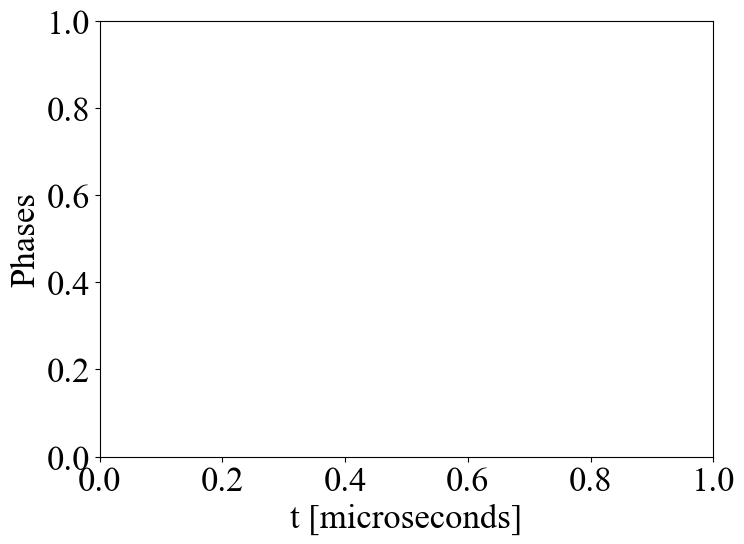